# Visualizing melspectograms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from librosa import display
import torch

/zhome/8a/1/127380/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Original spectograms

### STFT

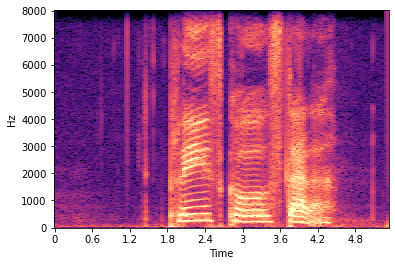

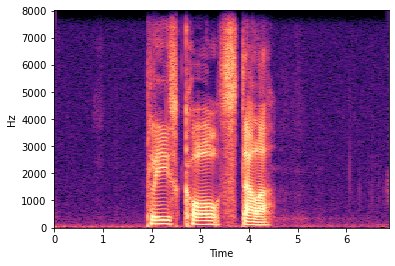

In [5]:
sub_org = 'p228'
sentence_org = '001' # OBS! all metadatafiles only contain first sentence.. we want to check conversion for different sentences to make to content encoder works

sub_trg = 'p227'
sentence_trg = '001' # OBS! all metadatafiles only contain first sentence.. we want to check conversion for different sentences to make to content encoder works

stft_org = np.load('/work3/dgro/VCTK-Corpus-0/stft/'+sub_org+'/'+sub_org+'_'+sentence_org+'_mic2.npy')
stft_trg = np.load('/work3/dgro/VCTK-Corpus-0/stft/'+sub_trg+'/'+sub_trg+'_'+sentence_trg+'_mic2.npy')

# STFT
plt.figure()
display.specshow(
    stft_org.T * 100 - 100,
    y_axis="fft",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('stftorg_'+sub_org+'_'+sentence_org+'.pdf')

plt.figure()
display.specshow(
    stft_trg.T * 100 - 100,
    y_axis="fft",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('stfttrg_'+sub_trg+'_'+sentence_trg+'.pdf')

### Mel

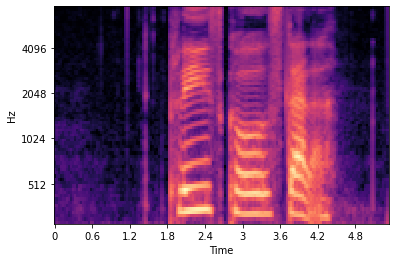

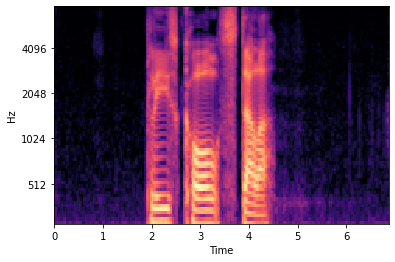

In [6]:
mel_org = np.load('/work3/dgro/VCTK-Corpus-0/spmel/'+sub_org+'/'+sub_org+'_'+sentence_org+'_mic2.npy')
mel_trg = np.load('/work3/dgro/VCTK-Corpus-0/spmel/'+sub_trg+'/'+sub_trg+'_'+sentence_trg+'_mic2.npy')

# MEL
plt.figure()
display.specshow(
    mel_org.T * 100 - 100,
    y_axis="mel",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('melorg_'+sub_org+'_'+sentence_org+'.pdf')

plt.figure()
display.specshow(
    mel_trg.T * 100 - 100,
    y_axis="mel",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('meltrg_'+sub_trg+'_'+sentence_trg+'.pdf')

## Converted spectograms

In [82]:
from model_vc_mel import Generator
from model_vc_stft import GeneratorSTFT
#from model_vc_wav import GeneratorWav

G_mel = Generator(32, 256, 512, 32)
G_stft = GeneratorSTFT(32, 256, 512, 32)
#G_wav1 = GeneratorWav(32, 256, 512, 32, 1)
#G_wav3 = GeneratorWav(32, 256, 512, 32, 3)
#G_wav5 = GeneratorWav(32, 256, 512, 32, 5)

checkpoint_mel = torch.load('chkpnt_spmel_reproducedAutoVC_new_22April23_1444_43_resumed_resumed_resumed_resumed.ckpt',map_location=torch.device('cpu'))
checkpoint_stft = torch.load('chkpnt_stft_stft_scratch_22April21_1408_13_resumed_resumed.ckpt',map_location=torch.device('cpu'))
#checkpoint_wav1 = 
#checkpoint_wav3 =
#checkpoint_wav5 =  

G_mel.load_state_dict(checkpoint_mel['state_dict'])
G_stft.load_state_dict(checkpoint_stft['state_dict'])
#G_wav1.load_state_dict(checkpoint_wav1['state_dict'])
#G_wav3.load_state_dict(checkpoint_wav3['state_dict'])
#G_wav5.load_state_dict(checkpoint_wav5['state_dict'])

<All keys matched successfully>

#### Load metadata 

In [83]:
metadata_mel = pickle.load(open('/work3/dgro/VCTK-Corpus-0/spmel/metadata.pkl', "rb"))
metadata_stft = pickle.load(open('/work3/dgro/VCTK-Corpus-0/stft_metadata.pkl', "rb"))

In [84]:
len(metadata_mel), len(metadata_stft)

(96, 96)

In [99]:
#print(np.array(metadata_stft[5])[0]), print(np.array(metadata_stft[4])[0])

org = 5 # p228
trg = 4 # p227

uttr_org_stft = metadata_stft[org][2]
uttr_trg_stft = metadata_stft[trg][2]
emb_org_stft = metadata_stft[org][1]
emb_trg_stft = metadata_stft[trg][1]

uttr_org_mel = metadata_mel[org][2]
uttr_trg_mel= metadata_mel[trg][2]
emb_org_mel = metadata_mel[org][1]
emb_trg_mel = metadata_mel[trg][1]

In [111]:
from data_loader import get_loader
main_dir = '/work3/dgro/VCTK-Corpus-0'
batch_size = 2
len_crop = 128 # (127*256)+1024=33536 for wav
model_type = 'spmel'
vcc_loader = get_loader(main_dir, batch_size, len_crop, model_type)

Finished loading the dataset...


In [112]:
data_iter = iter(vcc_loader)
x_real, emb_org = next(data_iter)

In [114]:
x_real.shape, emb_org.shape

(torch.Size([2, 128, 80]), torch.Size([2, 256]))

In [7]:
from model_vc_wav import GeneratorWav
from model_vc_wav import ConvTasNetEncoder 
import torch.nn as nn
import torch
import numpy as np

x_real = torch.from_numpy(np.load('x_real_wav.npy'))
emb_org = torch.from_numpy(np.load('emb_org_wav.npy'))

depth = 3
N = 512#80
L = 1024 #516#33536#516
S = 256 # L//2
bias=True

conv1x1 = nn.Conv1d(1, N, kernel_size = L, stride = S, padding = 0, bias=bias)

convolutions = []
for i in range(depth):
    conv_layer = nn.Sequential(
        nn.Conv1d(N, N, kernel_size = 3, stride=1, padding = 1,bias=bias),
        nn.PReLU(),
        nn.BatchNorm1d(N))
    convolutions.append(conv_layer)
convD = nn.ModuleList(convolutions)

x = x_real
print(x.shape)
x = x.permute(0,2,1)
print(x.shape)
x = conv1x1(x)
print(x.shape)
for conv in convD:
    x = conv(x)
    print(x.shape)

from model_vc_mel import Encoder, Decoder, LinearNorm, ConvNorm

dim_neck = 32
dim_emb = 256
freq = 32
dim_pre = 512

encoder = Encoder(dim_neck, dim_emb, freq)
decoder = Decoder(dim_neck, dim_emb, dim_pre)

encoder.convolutions[0][0] = ConvNorm(N+dim_emb, 512, kernel_size = 5, stride = 1, padding = 2)
decoder.linear_projection = LinearNorm(in_dim = 1024, out_dim = N)

x_convTas = x.permute(0,2,1).clone()
print('x_convtas shape:', x_convTas.shape)

# pass through AutoVC model 
x = x.permute(0,2,1)
print(x.shape)
codes = encoder(x, emb_org)

torch.Size([2, 33536, 1])
torch.Size([2, 1, 33536])
torch.Size([2, 512, 128])
torch.Size([2, 512, 128])
torch.Size([2, 512, 128])
torch.Size([2, 512, 128])
x_convtas shape: torch.Size([2, 128, 512])
torch.Size([2, 128, 512])


In [8]:
tmp = []
for code in codes:
    tmp.append(code.unsqueeze(1).expand(-1,int(x.size(1)/len(codes)),-1))
code_exp = torch.cat(tmp, dim=1)

encoder_outputs = torch.cat((code_exp, emb_org.unsqueeze(1).expand(-1,x.size(1),-1)), dim=-1)
print(encoder_outputs.shape)

gen_outputs = decoder(encoder_outputs)
print(gen_outputs.shape)

torch.Size([2, 128, 320])
torch.Size([2, 128, 512])


In [9]:
convolutions = []
for i in range(depth):
    conv_layer = nn.Sequential(
        nn.ConvTranspose1d(N, N, kernel_size = 3, stride=1, padding = 1, bias=bias),
        nn.PReLU(),
        nn.BatchNorm1d(N))
    convolutions.append(conv_layer)
convTD = nn.ModuleList(convolutions)

#L_T = 829

convT1x1 = nn.ConvTranspose1d(N, 1, kernel_size = L, stride = S, padding = 0, bias=bias)

x = gen_outputs.permute(0,2,1)
print(x.shape)
for convT in convTD:
    x = convT(x)
    print(x.shape)
x = convT1x1(x)
print(x.shape)

torch.Size([2, 512, 128])
torch.Size([2, 512, 128])
torch.Size([2, 512, 128])
torch.Size([2, 512, 128])
torch.Size([2, 1, 33536])


In [1]:
from model_vc_wav import GeneratorWav
dim_neck = 32
dim_emb = 256
freq = 32
dim_pre = 512

G_wav1 = GeneratorWav(dim_neck, dim_emb, dim_pre, freq, depth=1)
G_wav3 = GeneratorWav(dim_neck, dim_emb, dim_pre, freq, depth=3)
G_wav5 = GeneratorWav(dim_neck, dim_emb, dim_pre, freq, depth=5)

/zhome/8a/1/127380/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import numpy as np
x_real = torch.from_numpy(np.load('x_real_wav.npy'))
emb_org = torch.from_numpy(np.load('emb_org_wav.npy'))

In [3]:
x_CTencoder, x_identic, x_decoder, code_real = G_wav1(x_real, emb_org, emb_org)

torch.Size([2, 33536, 1])
torch.Size([2, 1, 33536])
torch.Size([2, 512, 128])
torch.Size([2, 128, 512])
torch.Size([2, 128, 512])
torch.Size([2, 128, 320])
torch.Size([2, 512, 128])
torch.Size([2, 33536, 1])


In [4]:
x_CTencoder, x_identic, x_decoder, code_real = G_wav3(x_real, emb_org, emb_org)

torch.Size([2, 33536, 1])
torch.Size([2, 1, 33536])
torch.Size([2, 512, 128])
torch.Size([2, 128, 512])
torch.Size([2, 128, 512])
torch.Size([2, 128, 320])
torch.Size([2, 512, 128])
torch.Size([2, 33536, 1])


In [5]:
x_CTencoder, x_identic, x_decoder, code_real = G_wav5(x_real, emb_org, emb_org)

torch.Size([2, 33536, 1])
torch.Size([2, 1, 33536])
torch.Size([2, 512, 128])
torch.Size([2, 128, 512])
torch.Size([2, 128, 512])
torch.Size([2, 128, 320])
torch.Size([2, 512, 128])
torch.Size([2, 33536, 1])


In [108]:
# conversion: G(uttr_org, emb_org, emb_trg)
# training: G(x_real, emb_org, emb_org)
len_pad = 128

_, x_identic_psnt, _ = G_mel(uttr_org_mel, emb_org_mel, emb_trg_mel)
uttr_trg_mel = x_identic_psnt[0, :-len_pad, :]


_, x_identic_psnt, _ = G_stft(uttr_org_stft, emb_org_stft, emb_trg_stft)
uttr_trg_stft = x_identic_psnt[0, :-len_pad, :]

#_, _, gen_outputs, _ = G_wav(uttr_org_wav, emb_org_wav, emb_org_wav)


X shape
(167, 80)


ValueError: cannot select an axis to squeeze out which has size not equal to one